In [6]:
import torch
from torch.utils.data import DataLoader, IterableDataset
from datasets import load_dataset
from transformers import CLIPModel, CLIPProcessor
from huggingface_hub import login
from datasets import load_from_disk
from torch.utils.data import Dataset

from sae.config import SaeConfig, TrainConfig
from sae.trainer import SaeTrainer  

from PIL import Image


In [2]:
dataset = load_from_disk(
    "mini-imagenet"
    )
dataset = dataset.shuffle(seed=35)
#seed is 35!!!!!!

class CLIPImageDataset(Dataset):
    """
    A map-style dataset that returns a single (image, label) pair
    in the format your model expects.
    """
    def __init__(self, hf_dataset, clip_processor):
        super().__init__()
        self.hf_dataset = hf_dataset   
        self.clip_processor = clip_processor

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        # Process the image with the CLIP processor
        proc = self.clip_processor(images=sample["image"], return_tensors="pt")
        # shape [1, 3, 224, 224], so we squeeze out the batch dimension
        pixel_values = proc["pixel_values"].squeeze(0)  # -> [3,224,224]
        label = sample.get("label", -1)
        return {
            "input_ids": pixel_values,
            "labels": label
        }


clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
feature_dataset = CLIPImageDataset(dataset, clip_processor)



In [57]:
from collections import defaultdict

import pickle 
from sae.sae import Sae
print("start")

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval()
vision_model = clip_model.vision_model

vision_model = clip_model.vision_model

# print(vision_model.encoder.layers[9])

activation = {}
def capture_activation(name):
    def hook(model, input, output):
        activation[name] = output[0][:, 0, :].detach()
    return hook

hook_handle = vision_model.encoder.layers[9].register_forward_hook(capture_activation("layer9"))

model_path = "clip_sae/vision_model.encoder.layers.11/"
device = "cpu"

sae = Sae.load_from_disk(model_path, device).eval()
neurons_topk = defaultdict(list)
i = 0
for image in feature_dataset:
    
    # if i%1000==0:
    #     print(i)
    #     print("DICT: ", len(neurons_topk))
    #     print(len(neurons_topk[int(idx)]))
    inp, label = image['input_ids'], image['labels']
    
    inp = inp.unsqueeze(0)
    vision_model(inp)
    latent_codes = sae.encode(activation['layer9'])
    top_acts = latent_codes.top_acts[0]
    top_indices = latent_codes.top_indices[0]
    for idx, act in zip(top_indices, top_acts):
        neurons_topk[int(idx)].append((i, label, float(act)))
        image, label = dataset[idx]['image'], dataset[idx]['label']
        print("LABEL: ", label)
        display(image)
    i += 1
        
        
    
        
    
  
with open("neurons_topk.pkl", "wb") as f:
    pickle.dump(neurons_topk, f)

start


TypeError: len() of a 0-d tensor

784
584


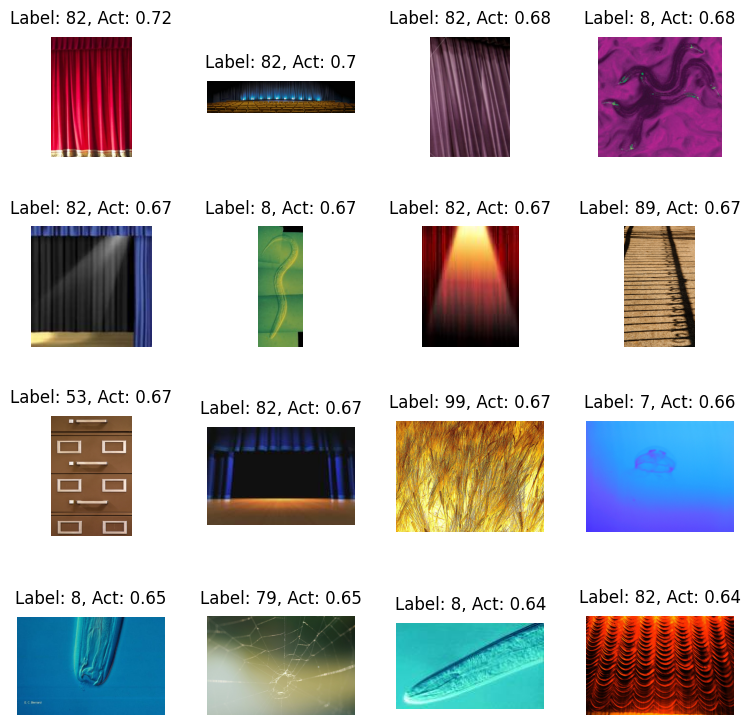

In [20]:
import numpy as np
import pickle
from datasets import load_from_disk
import matplotlib.pyplot as plt
import random
from PIL import Image


dataset = load_from_disk("mini-imagenet")
dataset = dataset.shuffle(seed=35)



n_neurons = 768*8
# neuron_idx = 5780
with open("neuron_data/third.pkl", "rb") as f:
    neurons_topk = pickle.load(f)
    # print(neurons_topk.keys())
    to_del = []
    print(len(neurons_topk))
    for key in neurons_topk:
        if len(neurons_topk[key])<16:
            to_del.append(key)
            
    for key in to_del:
        del neurons_topk[key]
    print(len(neurons_topk))

    neuron_idx = random.sample(list(neurons_topk.keys()), 1)[0]
    # neuron_idx = 2520

    topk = sorted(neurons_topk[neuron_idx], key=lambda x:-x[2])[0:16]

    images_list = []
    captions_list = []
    for idx, label, act in topk:
        idx -= 1
        images_list.append(dataset[idx]['image'])
        captions_list.append(f"Label: {label}, Act: {round(act, 2)}")
        # print(label)
        # display(dataset[idx]['image'])
    
        

    if len(images_list) < 16:
        
        print("BAD")
        
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()
    
    for idx, ax in enumerate(axes):
        
        image = images_list[idx]
        
        # Convert PIL Image to NumPy array if necessary
        if isinstance(image, Image.Image):
            image = np.array(image)
        
        ax.imshow(image)
        ax.set_title(captions_list[idx], fontsize=12, pad=10)
        ax.axis('off')
    
    plt.tight_layout(pad=3.0)
    # plt.savefig("example_grouping.png")
    plt.show()
    

    





In [ ]:
class_id = 63
filtered_dataset = dataset.filter(lambda sample: sample["label"] == class_id)

# Print some information about the filtered dataset
for info in filtered_dataset:
    image, label = info['image'], info['label']
    display(image)
    print(label)

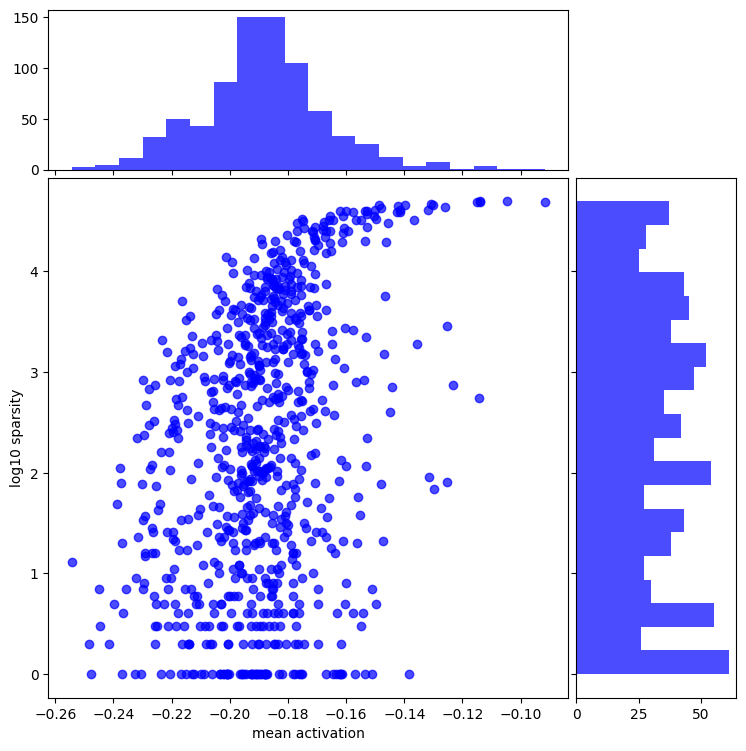

In [49]:
import matplotlib.pyplot as plt
import numpy as np


mean_activations = []
frequencies = []

for neuron_idx, records in neuron_dict.items():
    activations = [r[2] for r in records]  # Activation values (3rd element in tuple)
    mean_activation = np.log10(np.mean(activations))
    if mean_activation>0.8:
        print(neuron_idx)
    frequency = np.log10(len(records))
    
    mean_activations.append(mean_activation)
    frequencies.append(frequency)

# Convert to numpy arrays for plotting
mean_activations = np.array(mean_activations)
frequencies = np.array(frequencies)

# Create the main scatter plot with marginal histograms
fig = plt.figure(figsize=(8, 8))

# Main scatter plot
ax_scatter = fig.add_axes([0.1, 0.1, 0.65, 0.65])  # Main plot area
ax_scatter.scatter(mean_activations, frequencies, alpha=0.7, color="blue")
ax_scatter.set_xlabel("mean activation")
ax_scatter.set_ylabel("log10 sparsity")

# Top marginal histogram
ax_histx = fig.add_axes([0.1, 0.76, 0.65, 0.2], sharex=ax_scatter)
ax_histx.hist(mean_activations, bins=20, color="blue", alpha=0.7)
# ax_histx.set_ylabel("Count")  # Add label for the top histogram
ax_histx.tick_params(axis="x", labelbottom=False)  # Hide x-ticks for cleaner look

# Right marginal histogram
ax_histy = fig.add_axes([0.76, 0.1, 0.2, 0.65], sharey=ax_scatter)
ax_histy.hist(frequencies, bins=20, color="blue", alpha=0.7, orientation="horizontal")
# ax_histy.set_xlabel("Count")  # Add label for the right histogram
ax_histy.tick_params(axis="y", labelleft=False)  # Hide y-ticks for cleaner look

# Show the plot
plt.savefig('evaluation/histogram.png')
plt.show()




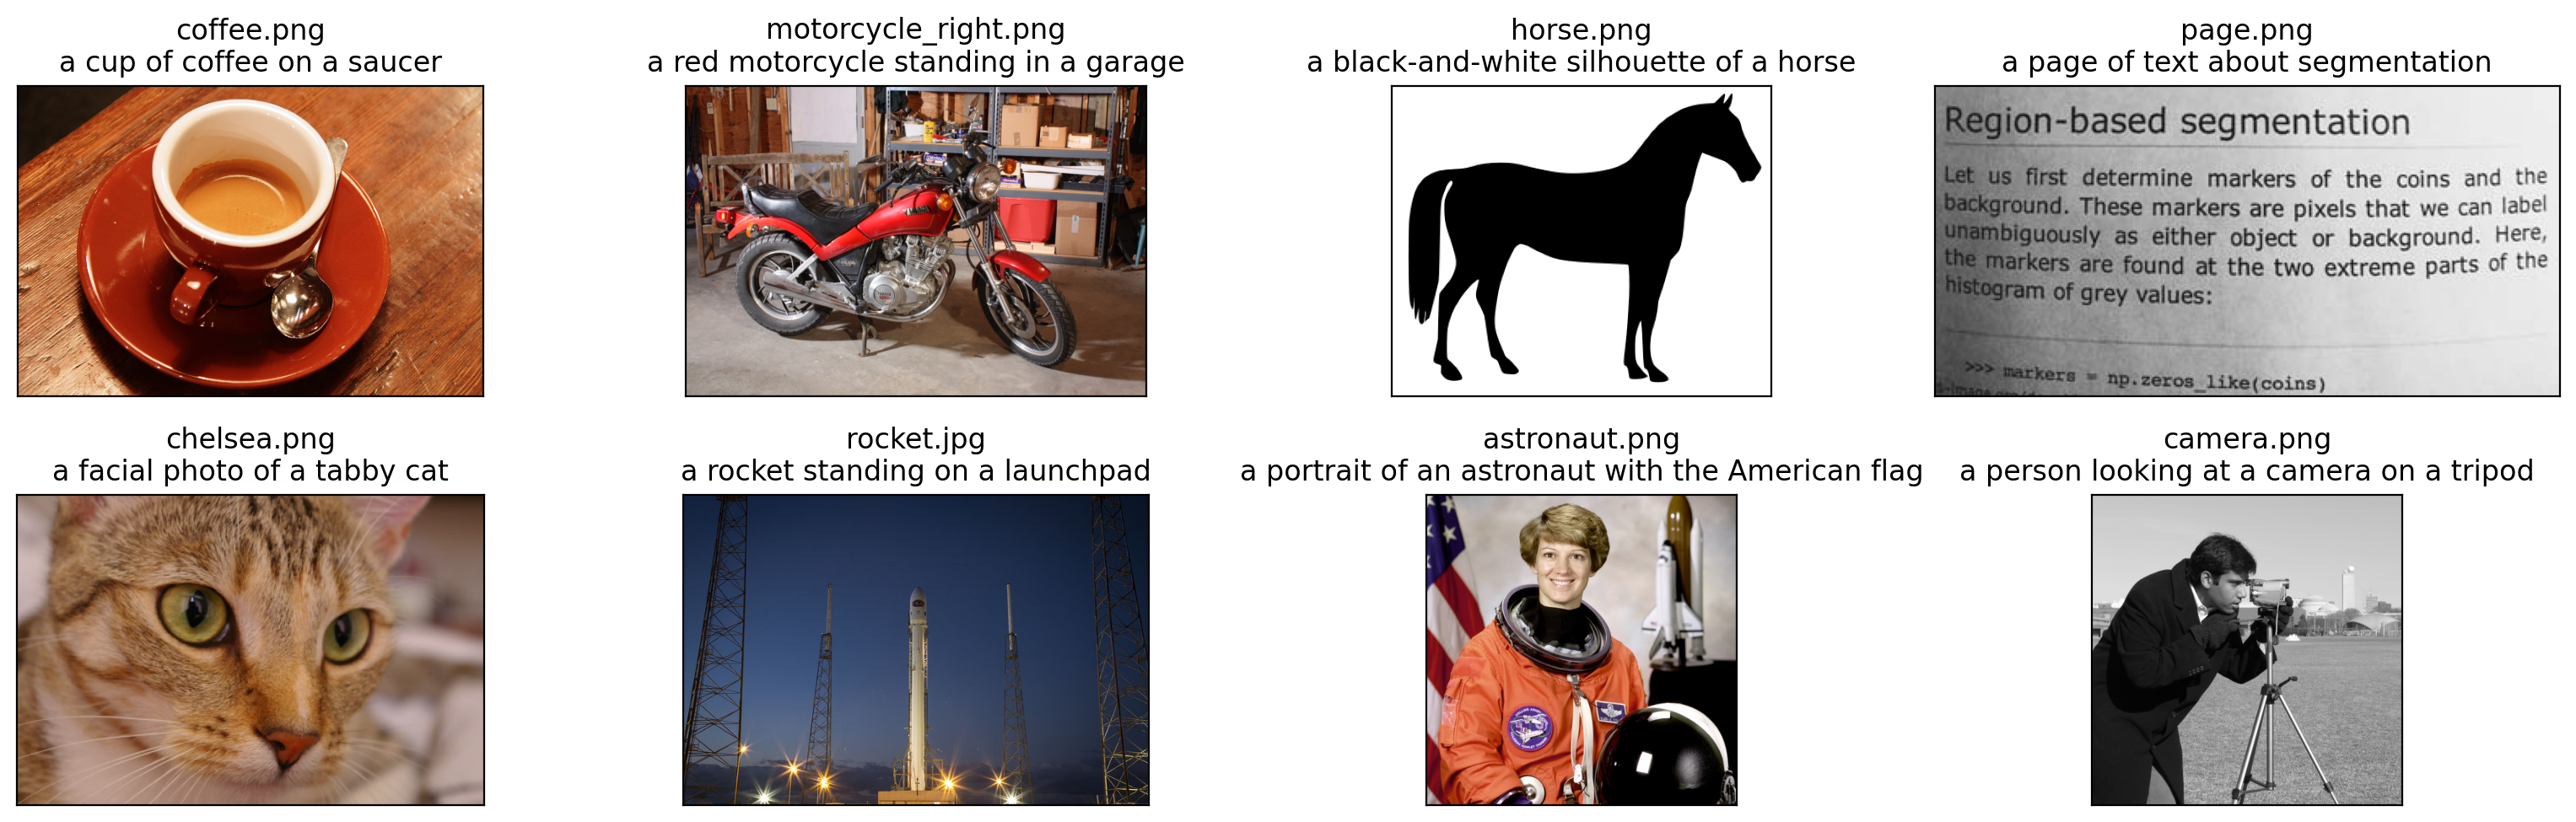

In [59]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import clip

from collections import OrderedDict
import torch

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()
plt.savefig('evaluation/test_images.png')


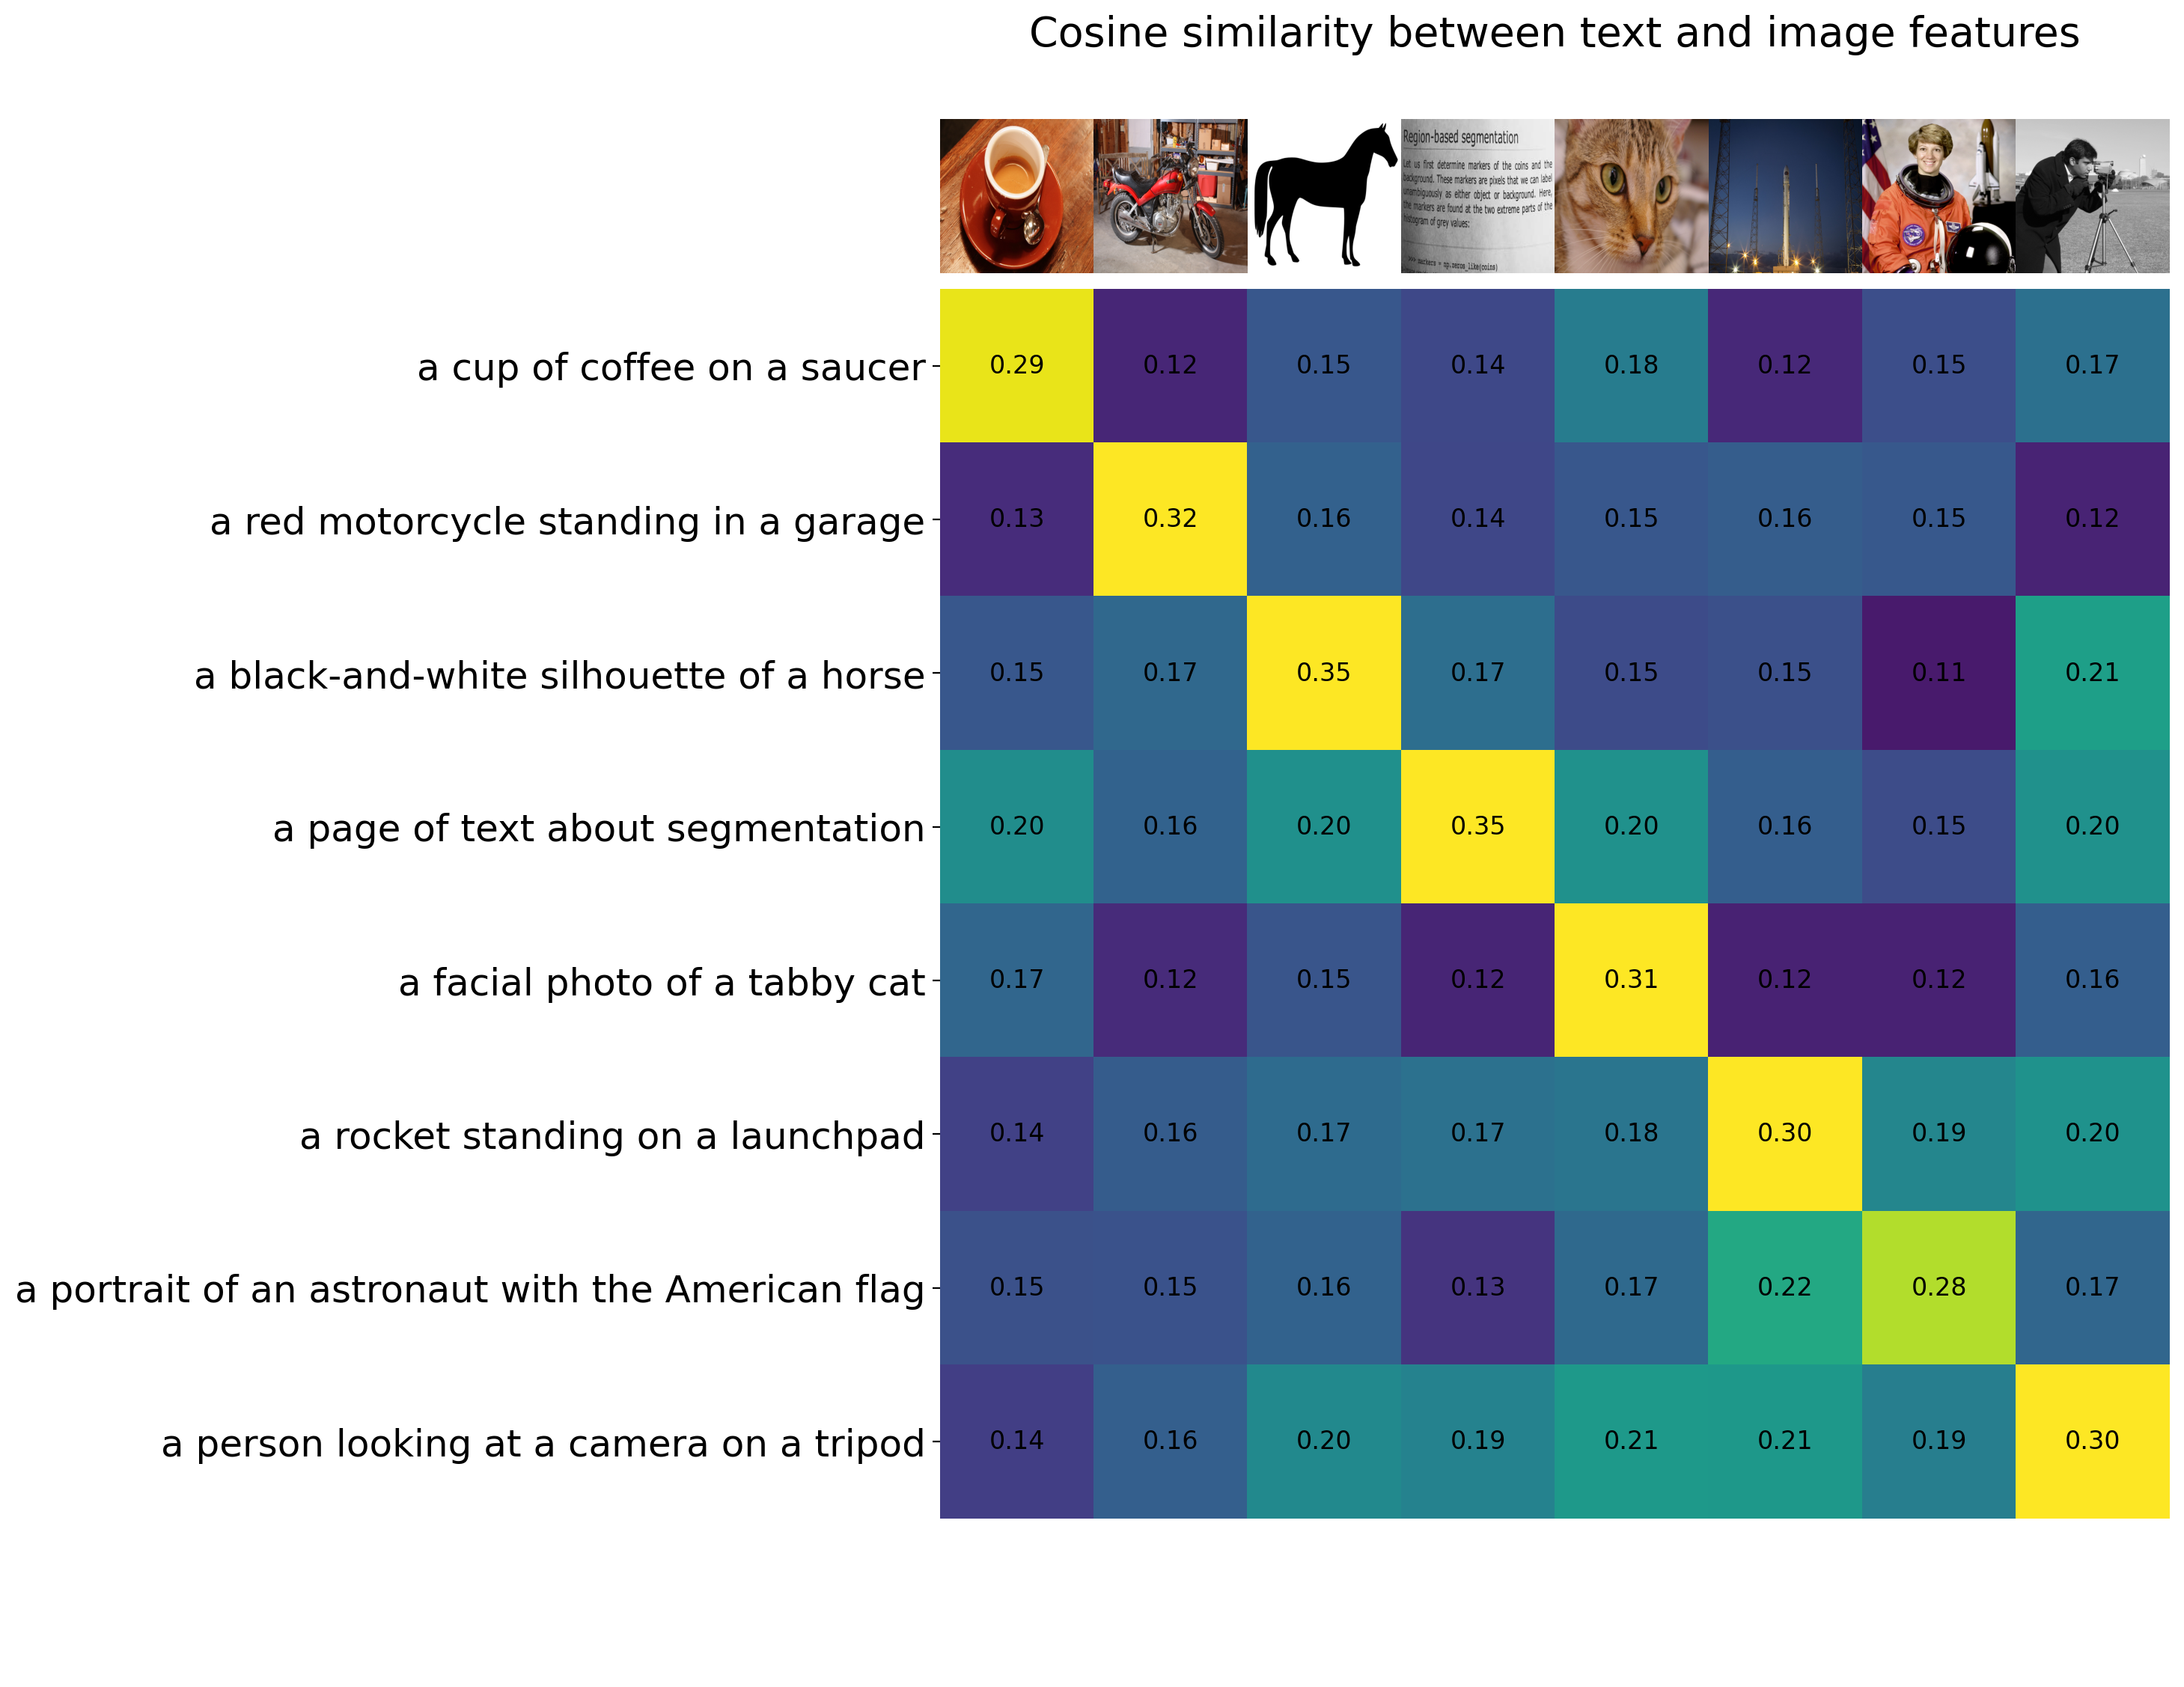

In [61]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)
plt.savefig('evaluation/without_sae.png')

In [52]:
import torch
import torch.nn as nn

class SAELayerInterception(nn.Module):
    def __init__(self, original_layer: nn.Module, sae: nn.Module):
        """
        Args:
            original_layer: The original CLIP transformer block you want to intercept.
            sae: Your trained SAE (nn.Module) that operates on the CLS token only.
        """
        super().__init__()
        self.original_layer = original_layer
        self.sae = sae

    def forward(self, hidden_states, *args, **kwargs):
        """
        hidden_states: [batch_size, seq_len, hidden_dim]
        We'll run the original layer normally, then replace only the CLS token
        (index 0) with the SAE output.
        """
        # 1) Run the original attention + MLP layer
        outputs = self.original_layer(hidden_states, *args, **kwargs)
        out = outputs[0]  # shape: [B, seq_len, hidden_dim]

        # 2) Extract the CLS token and the rest of the sequence
        cls_token = out[:, 0, :]           # [B, hidden_dim]
        rest_tokens = out[:, 1:, :]        # [B, seq_len-1, hidden_dim]

        # 3) Pass only the CLS token through the SAE
        #    => shape stays [B, hidden_dim]
        cls_sae = self.sae(cls_token)

        # 4) Reassemble: put the modified CLS token back with the rest
        out_sae = torch.cat([cls_sae.sae_out.unsqueeze(1), rest_tokens], dim=1)
        # out_sae is now [B, seq_len, hidden_dim]

        # 5) Return updated hidden_states
        #    The rest of the outputs (e.g. attentions) remain unchanged
        return (out_sae,) + outputs[1:]


In [53]:
from transformers import CLIPModel
import torch
from sae.sae import Sae

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda().eval()
device = 'cuda'
sae = Sae.load_from_disk('models/clip_sae_11_k64_exp4/vision_model.encoder.layers.11', device)


LAYER_IDX = 10
original_layer = model.vision_model.encoder.layers[LAYER_IDX]

model.vision_model.encoder.layers[LAYER_IDX] = SAELayerInterception(
    original_layer,
    sae
)

Dead Mask is none


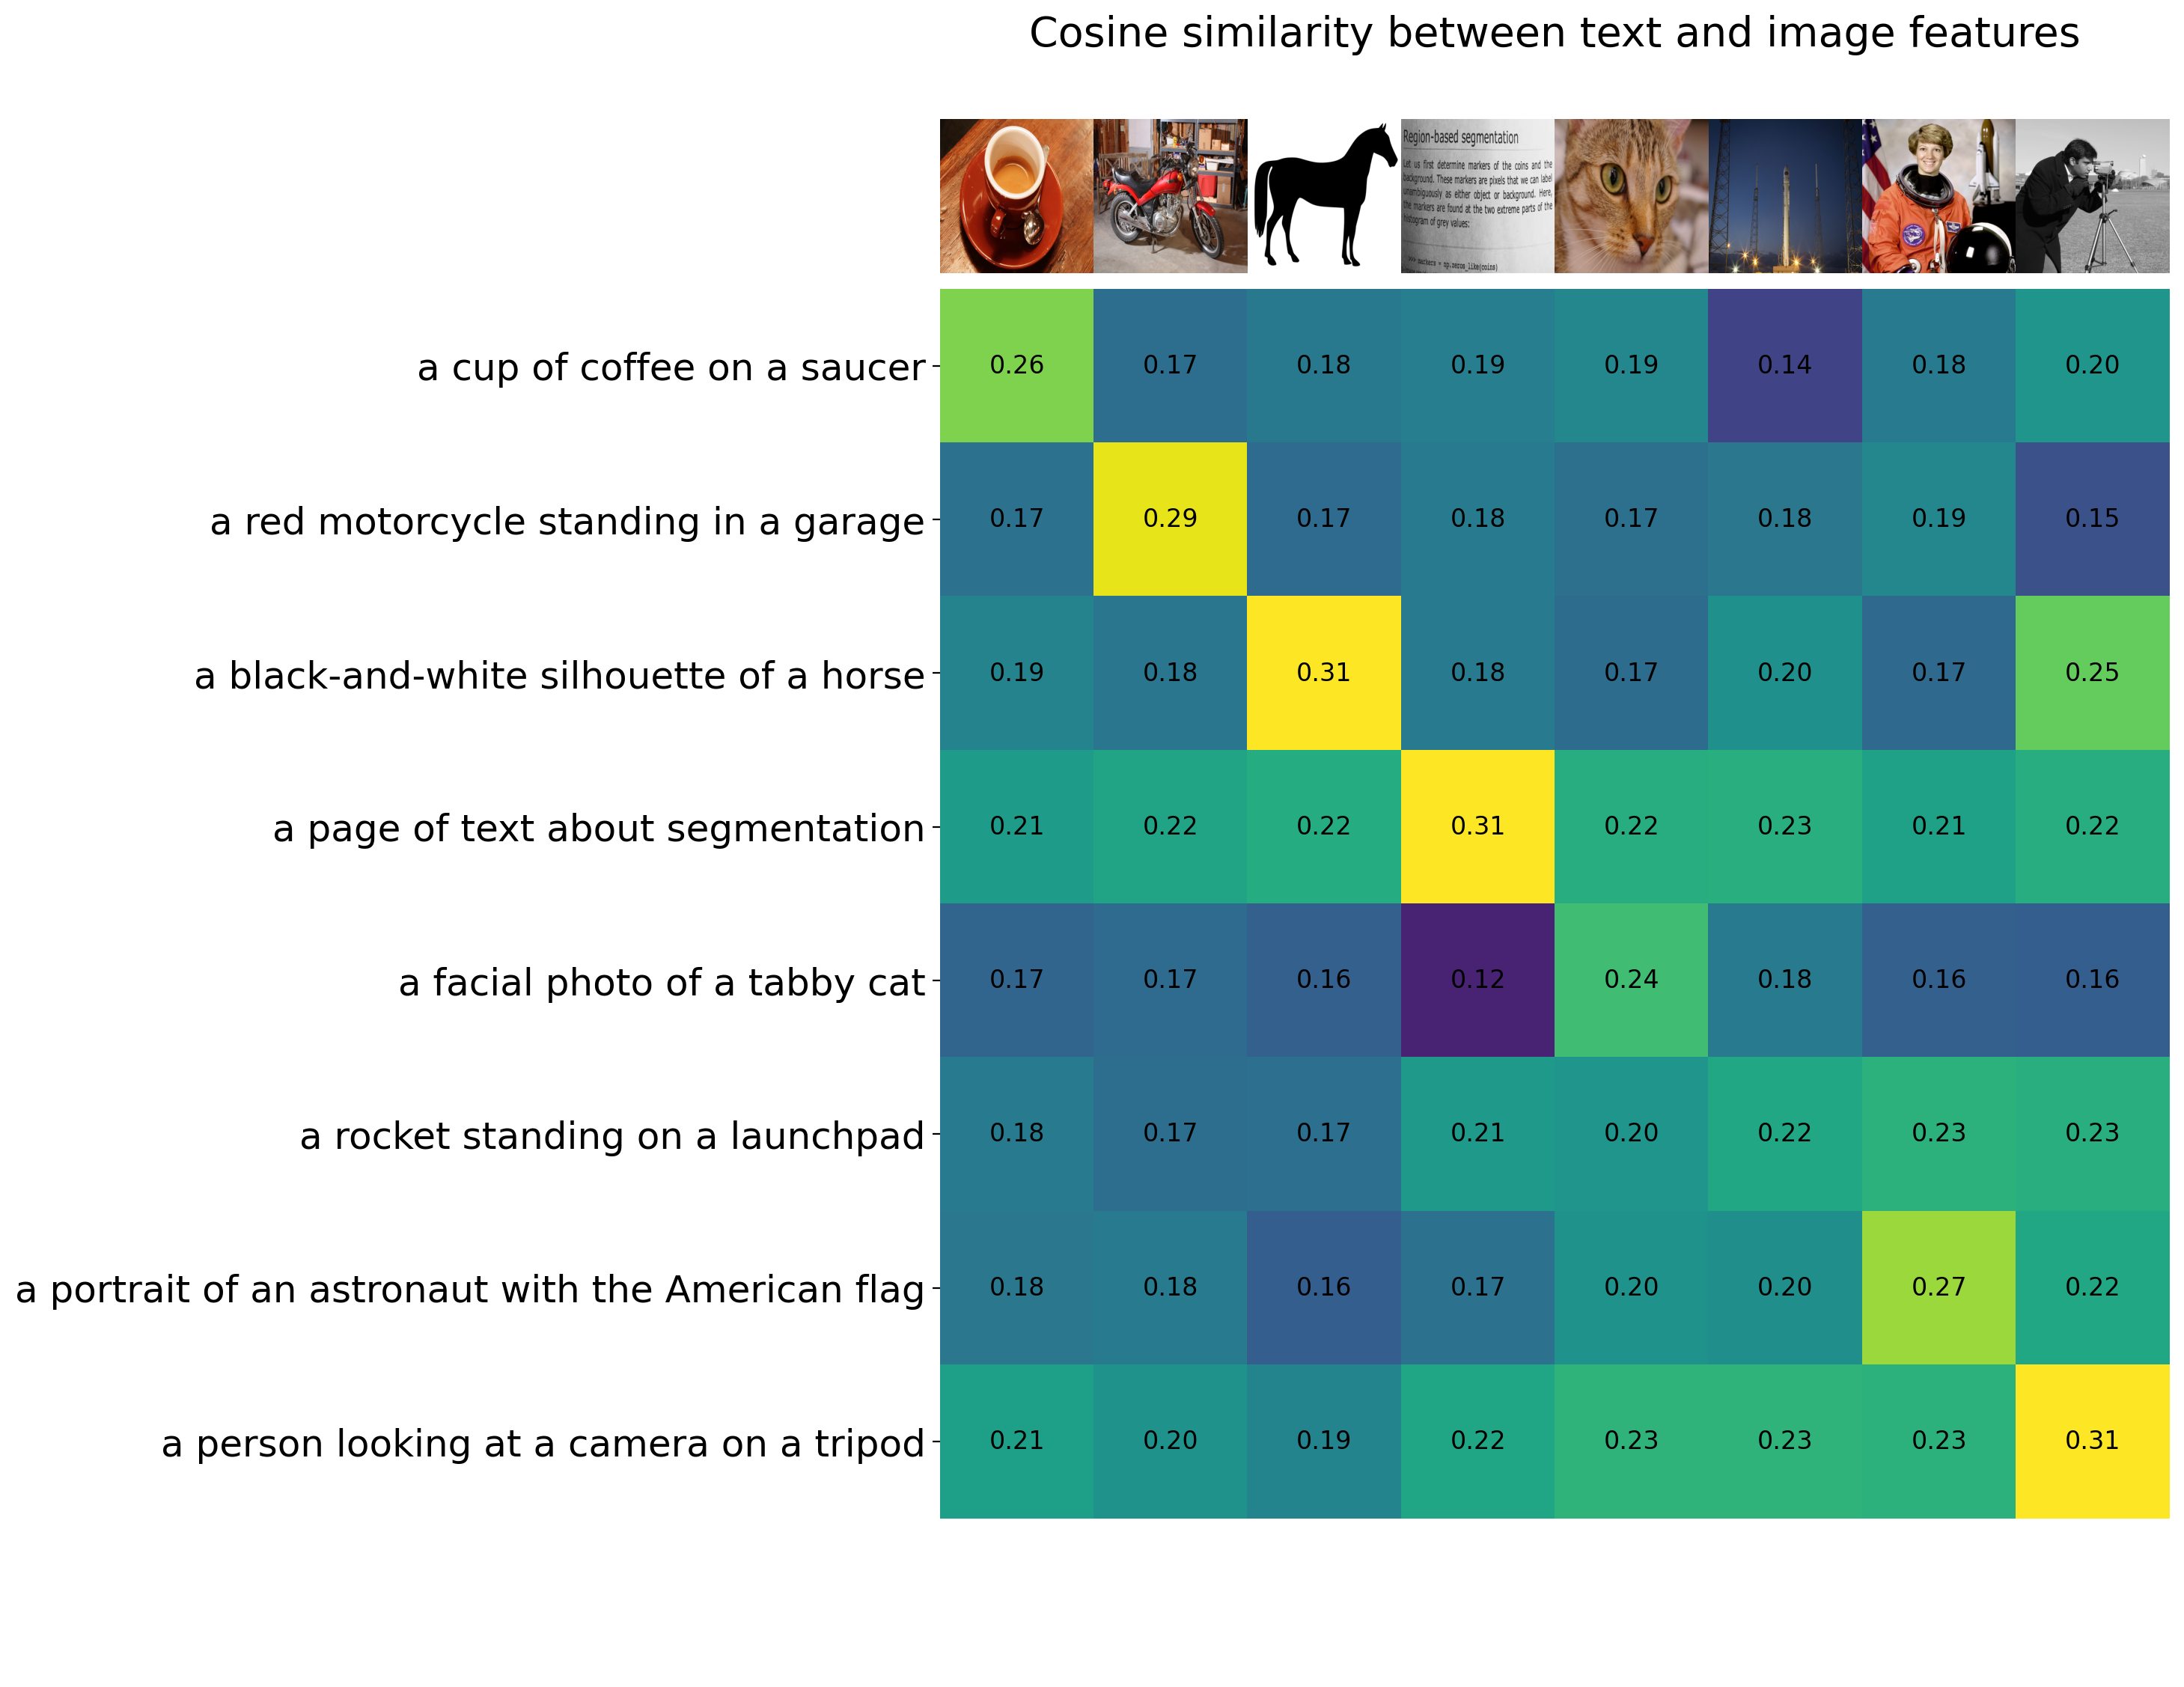

In [55]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

with torch.no_grad():
    image_features = model.get_image_features(image_input).float()
    text_features = model.get_text_features(text_tokens).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)
plt.savefig('evaluation/with_sae.png')